<a href="https://colab.research.google.com/github/MazurovaNN/Data-Science/blob/main/lesson10_Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Выявление аномалий в данных

### Квантили

В `pandas` определенный квантиль набора данных можно найти при помощи атрибута `quantile`

Далее будем работать с данными предоставленными Numenta Anomaly Benchmark (NAB) https://github.com/numenta/NAB. А конкретно с данными такси в Нью-Йорке

In [ ]:
import pandas as pd

taxi_data = pd.read_csv('nyc_taxi.csv')
taxi_data['timestamp'] = taxi_data['timestamp'].astype('datetime64')
taxi_data.head(10)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
5,2014-07-01 02:30:00,2873
6,2014-07-01 03:00:00,2369
7,2014-07-01 03:30:00,2064
8,2014-07-01 04:00:00,2221
9,2014-07-01 04:30:00,2158


In [ ]:
# Выведем 20й и 80й квантили
print('20% квантиль данных:', taxi_data['value'].quantile(.2))
print('80% квантиль данных:', taxi_data['value'].quantile(.8))

# Таким образом можно фильтровать данные
data_33_quantile = taxi_data[taxi_data['value'] <= taxi_data['value'].quantile(.33)]
data_33_quantile.shape

20% квантиль данных: 7028.400000000001
80% квантиль данных: 20834.800000000003


(3406, 2)

### Визуализируем квартили

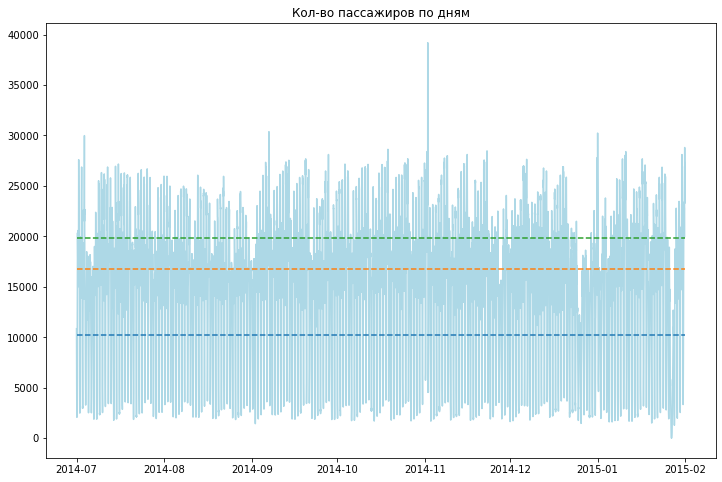

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))
plt.plot(taxi_data['timestamp'], taxi_data['value'], color = '#add8e6')
plt.plot((taxi_data['timestamp'][0], taxi_data['timestamp'].iloc[-1]),
         (taxi_data['value'].quantile(.25), taxi_data['value'].quantile(.25)), label = 'Q1',
        ls = '--')

plt.plot((taxi_data['timestamp'][0], taxi_data['timestamp'].iloc[-1]),
         (taxi_data['value'].quantile(.50), taxi_data['value'].quantile(.5)), label = 'Q2',
        ls = '--')

plt.plot((taxi_data['timestamp'][0], taxi_data['timestamp'].iloc[-1]),
         (taxi_data['value'].quantile(.75), taxi_data['value'].quantile(.75)), label = 'Q3',
        ls = '--')

plt.title('Кол-во пассажиров по дням')

plt.show()

### Диаграмма размаха

У `pd.DataFrame` есть атрибут `boxplot` при помощи которого можно построить диаграмму размаха

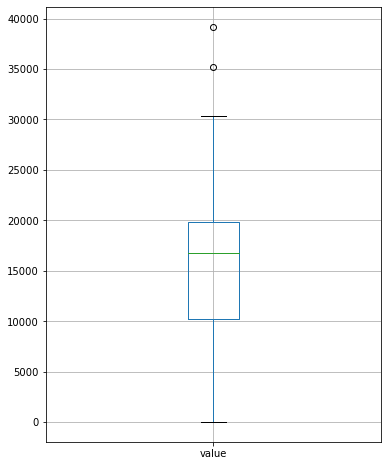

In [ ]:
plt.figure(figsize = (6, 8))
taxi_data.boxplot()
plt.show()

### KNN

Напишем своими руками KNN классификатор для двумерного случая

Для начала создадим данные

In [ ]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt

# Функция для генерации данных
def data_generator (classes_num, class_elements_amnt):
    data = []
    for class_ in range(classes_num):
        # Выбиарем случайный центр из двумерного нормального распределения на участке от 0 до 10
        X, Y = np.random.randn() * 10, np.random.randn() * 10
        # Выбираем случайно элементы класса с отклонением в 0.7
        for el in range(class_elements_amnt):
            data.append([ [.7 * np.random.randn() + X, .7 * np.random.randn() + X], class_])
    return data

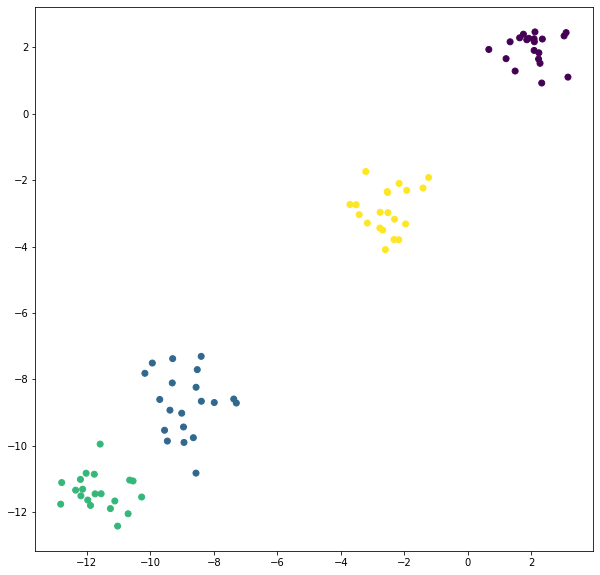

In [ ]:
def plot_data(classes_num, class_elements_amnt):
    trainData = data_generator(classes_num, class_elements_amnt)
    plt.figure(figsize = (10, 10))
    plt.scatter([trainData[i][0][0] for i in range(len(trainData))],
               [trainData[i][0][1] for i in range(len(trainData))],
               c=[trainData[i][1] for i in range(len(trainData))])
    plt.show()

plot_data(4, 20)

Поделим данные на тренировочную и тестовые выборки

In [ ]:
data = data_generator(4, 40)
print(len(data))

160


In [ ]:
def train_test_split(data, test_size = 0.2, random_state = 1):
    L = len(data)
    np.random.shuffle(data)
    train, test = data[:int((1-test_size) * L)], data[int((1-test_size) * L):]
    return train, test



train, test = train_test_split(data)

Расстояние до объектов тренировочной выборки рассчитывается как $$D_E = \sqrt{\sum \limits_{i}^{n}(x_i\,-\,y_i)^2}$$ где n - кол-во атрибутов

Напишем функцию, реализующую алгоритм

In [ ]:
def KNN (X_train, X_test, class_num, k = 5):

    # Расстояние между точками на плоскости
    def point_dist (a, b):
        return np.sqrt((a[0][0] - b[0])**2 + (a[0][1] - b[1])**2)

    pred = []

    for point in X_test:
        # Находим расстояние от точки до всех точек тренировочной выборки
        dist = [ [point_dist(point, X_train[i][0]), X_train[i][1]] for i in range(len(X_train))]

        # Находим K ближащих точек
        stat = [0 for i in range(class_num)]
        for d in sorted(dist)[0:k]:
            stat[d[1]] += 1

        # Присваиваем точке самый распространенный класс среди K соседей (Мажоритарное голосование)
        pred.append( sorted(zip(stat, range(class_num)), reverse=True)[0][1] )
    return pred

In [ ]:
pred = KNN(train, test, 4, k = 7)
pred

[1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 3,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 3,
 0,
 1,
 0,
 1,
 0,
 3,
 0,
 0,
 1,
 0,
 3,
 3]

### KNN в sklearn

В библиотеке `sklearn` KNN классификатор реализован как класс `KNeighborsClassifier`

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Создадим и обучим модель
knn = KNeighborsClassifier()
knn.fit([train[i][0] for i in range(len(train))], [train[i][1] for i in range(len(train))])
pred = knn.predict([test[i][0] for i in range(len(test))])
pred

array([1, 0, 1, 0, 1, 2, 1, 1, 2, 3, 1, 2, 2, 1, 2, 0, 1, 2, 2, 3, 0, 1,
       0, 1, 0, 3, 0, 0, 1, 0, 3, 3])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(pred, [test[i][1] for i in range(len(test))])

1.0

### KNN для поиска аномалий в данных

KNN можно использовать для поиска аномалий в новых данных на основе исторических. Приведем задачу пассажиров такси к задаче классификации. Будем считать аномальными все данные, которые находятся вне 95% квартиля

In [ ]:
taxi_data['label'] = [1 if i > taxi_data['value'].quantile(.95) else 0 for i in taxi_data['value']]
taxi_data.sample(10)

,timestamp,value,label
3272,2014-09-07 04:00:00,10896,0
187,2014-07-04 21:30:00,14021,0
10142,2015-01-28 07:00:00,14063,0
3824,2014-09-18 16:00:00,13635,0
3335,2014-09-08 11:30:00,17370,0
9070,2015-01-05 23:00:00,11660,0
5127,2014-10-15 19:30:00,26273,1
7913,2014-12-12 20:30:00,25190,1
6152,2014-11-06 04:00:00,3122,0
3478,2014-09-11 11:00:00,16583,0


In [ ]:
from sklearn.model_selection import train_test_split
X = taxi_data['value'].to_numpy().reshape(-1, 1)
y = taxi_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print(pred[:10])

[0 0 0 0 0 0 0 0 0 0]


### Isolation forest

Isolation forest находится в модуле `ensemble` библиотеки `sklearn`

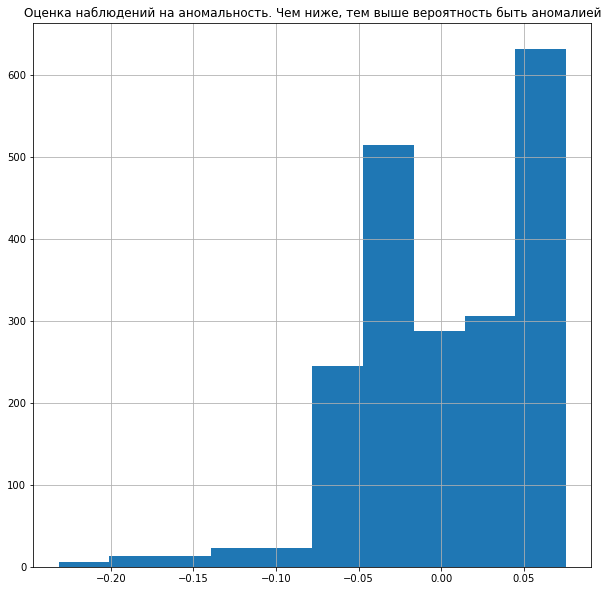

In [ ]:
from sklearn.ensemble import IsolationForest

# Создадим и обучим модели
i_for = IsolationForest(n_estimators = 300, random_state = 42)

i_for.fit(X_train)
pred_train = i_for.predict(X_train)
pred_test = i_for.predict(X_test)

# Оценка аномальности
pred_train_prob = i_for.decision_function(X_train)
pred_test_prob = i_for.decision_function(X_test)

plt.figure(figsize = (10, 10))
pd.Series(pred_test_prob).hist()
plt.title('Оценка наблюдений на аномальность. Чем ниже, тем выше вероятность быть аномалией')
plt.show()